### Stacking Ensemble - Blending
Assuming we have $n$ models and the reconstructed matrix by the
$i$-th model is denoted by $\hat{A}$, the final prediction would be
$$\hat{A} = w_0 + \sum_{i=1}^{n}w_i \hat{A}^i$$

$\hat{A}^i$ fixed, only learn $w_i$ for $i = 0, 1, ..., n$

We split the data into training and holdout set (say 95% - 5%, or try different split ratios). The level-0 $n$ models are trained on the training set. The weights $w_i$ of the level-1 ensemble model are then learned on the holdout set.

#### Possible improvements:
- Observe error on validation set to determine the number of epochs
- K Fold Cross Validation, and average over weights to get final weights of Ensemble

In [1]:
# model-1: SVP - 10 instances k=1,3,5,..19
# model-2: Regularized SVD - 10 instances
# model-3: SVT - 10 instances
import numpy as np
import pandas as pd
n = 3 # number of models
data = pd.read_csv("./data/data_train.csv")
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Id,Prediction
0,r6005_c178,5
1,r3147_c30,4
2,r25_c230,3
3,r9159_c230,3
4,r6048_c331,5


In [2]:
users, movies = \
        [np.squeeze(arr) for arr in \
        np.split(data.Id.str.extract("r(\d+)_c(\d+)").values.astype(int) - 1, 2, axis=-1)]
predictions = data.Prediction.values
predictions = predictions.astype('float')

In [3]:
train_size = int(0.97 * users.shape[0])
A = np.full((10000, 1000), 0)
for user , movie , pred in zip(users[:train_size], movies[:train_size], predictions[:train_size]):
    A[user][movie] = pred
W = (A > 0).astype(int)
import utils
norm_A, mean_A, stddev_A = utils.zscore_masked_items(A, W)

In [4]:
sample_pd = pd.read_csv("./data/sampleSubmission.csv")
test_users, test_movies = \
    [np.squeeze(arr) for arr in \
    np.split(sample_pd.Id.str.extract("r(\d+)_c(\d+)").values.astype(int) - 1, 2, axis=-1)]

In [5]:
## Ensemble
## Assume rec_A is given
y_val = predictions[train_size:] #target of the ensemble
X_ensemble = np.ones((1, y_val.shape[0]))
raw_preds = np.empty((test_users.shape[0], 30),dtype=float)
model_n = 0
from SVP import SVP
rank_schedule = [1,3,5,7,9,11,15,20,25,30]
for k in range(10):
    model = SVP(A, K=rank_schedule[k])
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

from SVT import SVT
#eta, tau, epochs
schedule = [(1.2,2000,25), (1.5,2000,25), (1.2,1000,15), (1.2,1000,10),
(2.0,2000,25), (2.0,1000,15), (2.5,3000,10), (3.0,3000,10), (3.5,2000,15), (3.5,1000,25)]

for k in range(10):
    eta, tau, epochs = schedule[k]
    model = SVT(A, eta, tau, epochs)
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

from RSVD import RSVD
features_schedule = [50,100,150,200,250,300,324,350,400,450]
for k in range(10):
    features = features_schedule[k]
    model = RSVD(A, features=features)
    errors = model.train()
    print(errors)
    rec_A = model.reconstruct_matrix()
    raw_preds[:,model_n] = rec_A[test_users, test_movies]
    model_n += 1
    y_pred = rec_A[users[train_size:], movies[train_size:]]
    X_ensemble = np.vstack([X_ensemble, y_pred])

print(X_ensemble.shape)
X_ensemble = X_ensemble.T


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


{'train_rmse': [1.013523894907028, 1.01762920478639, 1.002641286884714, 0.9921605956125014, 0.9916836456094216, 0.9915170729837548, 0.99145472349351, 0.9914319138754139, 0.9914239449359404, 0.9914212996020426], 'test_rmse': []}


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


{'train_rmse': [1.0071344949706875, 1.0422144314130048, 1.1181988438626018, 1.1074908154284149, 0.9777714805391012, 0.9757458953799432, 0.9750575971712054, 0.9748143271742408, 0.9747303865751898, 0.9747026421516217], 'test_rmse': []}


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


{'train_rmse': [1.0116337416681986, 1.1433175411697571, 1.5185993313045314, 1.4985284942878543, 0.9757908158504479, 0.9724982596485081, 0.9715120099800926, 0.9711729734351658, 0.971056954203605, 0.9710187097967996], 'test_rmse': []}


100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


{'train_rmse': [1.0158208594759672, 1.2283681558561446, 1.8613118996226252, 1.8640228986827854, 0.9698873776495165, 0.9652260419281591, 0.9638565790758092, 0.9633889101938643, 0.9632292446763804, 0.9631766545454238], 'test_rmse': []}


100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


{'train_rmse': [1.027259343490714, 1.3878160662738468, 2.467295200689509, 2.510868218480911, 0.9645119861942495, 0.9588800311558721, 0.9572779874912859, 0.9567337136489258, 0.9565481383718017, 0.9564870385298514], 'test_rmse': []}


100%|██████████| 10/10 [00:37<00:00,  3.70s/it]


{'train_rmse': [1.0423553225819815, 1.5818833986612504, 3.1066208657778773, 3.1768541052091557, 0.9601808103966305, 0.9528309923636237, 0.9508925423474701, 0.9502464398484424, 0.9500274583957841, 0.9499555011211259], 'test_rmse': []}


100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


{'train_rmse': [1.0817341033843495, 1.9916258530000552, 4.324439077885625, 4.4336335014667805, 0.9533427380392816, 0.9426586295339741, 0.9399805533949277, 0.9390993467149721, 0.9388018815483787, 0.9387042643272347], 'test_rmse': []}


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


{'train_rmse': [1.1310358298093752, 2.4294004944529086, 5.578356278998547, 5.769666535160524, 0.9550519469035246, 0.9369227215282737, 0.9324950038826719, 0.9310489778491503, 0.9305620612302297, 0.9304024055982572], 'test_rmse': []}


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


{'train_rmse': [1.1835166732376972, 2.8352286870760968, 6.707402249980435, 6.954362740647258, 0.9477300101497802, 0.9247760136598382, 0.9193723397476558, 0.9176258181666355, 0.9170396568693424, 0.9168476692140026], 'test_rmse': []}


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


{'train_rmse': [1.237723060183851, 3.198715772109691, 7.666915796470727, 7.946664755878975, 0.9436464767711794, 0.9173563099085964, 0.9113257390637832, 0.9093913211670461, 0.9087436691771407, 0.9085317110803419], 'test_rmse': []}


100%|██████████| 25/25 [02:11<00:00,  5.26s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0285543171272744, 1.0100787371417852, 1.0033981364070874, 1.0007058004971219, 0.999368034728137, 0.9985161096405523, 0.9978574161112351, 0.9972886582808421, 0.9927596140137037, 0.9864156620324012, 0.9807306939277435, 0.978094116333172, 0.9740564961233434, 0.9685768748479431, 0.9618859928744659], 'test_rmse': []}


100%|██████████| 25/25 [02:17<00:00,  5.50s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0230386244989793, 1.0055144103914946, 1.0009099374352133, 0.9992345780446565, 0.9982722640472803, 0.9975230813401121, 0.994360491120899, 0.9861582329300288, 0.9795775711961924, 0.976525582723984, 0.9695956837053465, 0.9616321995465322, 0.9534162268410428, 0.9387916224035711, 0.9189338423123591, 0.8914919544659069, 0.8611562613624256], 'test_rmse': []}


100%|██████████| 15/15 [01:28<00:00,  5.89s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0183324579519992, 1.006373928023675, 1.0017422212113425, 0.9995322965762902, 0.9911911831364971, 0.9830693304661473, 0.974011093636583, 0.962127162103013, 0.9403444662334065, 0.9025758663483473], 'test_rmse': []}


100%|██████████| 10/10 [00:55<00:00,  5.56s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0183324579519992, 1.006373928023675, 1.0017422212113425, 0.9995322965762902, 0.9911911831364971], 'test_rmse': []}


100%|██████████| 25/25 [02:17<00:00,  5.48s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0151110534139873, 1.001279306845793, 0.9990365310068235, 0.9979293440997297, 0.9970223511673924, 0.9855366235420744, 0.9780309400890664, 0.9722424959694969, 0.9611692388319264, 0.9484759144671381, 0.9260913136105, 0.8904607024124427, 0.8483812211661265, 0.8030132042855117, 0.7590383727461619, 0.71954404942252, 0.6806628759414585, 0.644422386146764, 0.6102535505839246], 'test_rmse': []}


100%|██████████| 15/15 [01:31<00:00,  6.11s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0078915000309958, 1.0000621278720894, 0.9908395382015842, 0.9767343678299973, 0.9546652376609558, 0.9006004207798088, 0.8132478420717311, 0.7279262492364393, 0.6522403843825585, 0.5845504671235956, 0.5233917958940688, 0.4698956281139885], 'test_rmse': []}


100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0245347101909772, 1.00032535442433, 0.9989615587841518], 'test_rmse': []}


100%|██████████| 10/10 [01:07<00:00,  6.70s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0097488630289668, 0.9992579714638644, 0.9982302411494386, 0.9972473024115504], 'test_rmse': []}


100%|██████████| 15/15 [01:32<00:00,  6.17s/it]


{'train_rmse': [1.0291572832409002, 1.0291572832409002, 1.0291572832409002, 1.0151110534139873, 0.999517443091991, 0.9974004367629368, 0.9821408638123589, 0.9718279172754501, 0.952800090218754, 0.9126674581467251, 0.8486540545096963, 0.7814021156119825, 0.7305655739762784, 0.6838323215712526, 0.6598280118731417], 'test_rmse': []}


100%|██████████| 25/25 [02:32<00:00,  6.09s/it]


{'train_rmse': [1.0291572832409002, 1.0215875390047369, 0.999834716162216, 0.9756044307639884, 0.9200238790898649, 0.8251330406251912, 0.7434210508736311, 0.7573849745925092, 0.6635760502935988, 0.614664407921006, 0.6557287468468945, 0.7084632106808069, 0.6536910224637648, 0.676550578414313, 0.6903666367940083, 0.7176532727335794, 0.7150883050551232, 0.7358905433136185, 0.750602264083524, 0.7779089735884961, 0.775092513014145, 0.7900062707646807, 0.7956190171853278, 0.8000291788472862, 0.785331877649766], 'test_rmse': []}


100%|██████████| 15/15 [04:42<00:00, 18.85s/it]


{'train_rmse': [1.0251693691930832, 1.0127709095141435, 1.0092092905278651, 1.0066656555878355, 1.0012215472817834, 0.9929489222120891, 0.9806463366922077, 0.9667681117202083, 0.9469125491535574, 0.9270184549090025, 0.9026113332424737, 0.8785619383035117, 0.8541556272023526, 0.8326410164318072, 0.8145797395580406], 'test_rmse': []}


100%|██████████| 15/15 [04:33<00:00, 18.23s/it]


{'train_rmse': [1.0252196594115617, 1.013483602101695, 1.0102592197837428, 1.007845203479954, 1.003798946921732, 0.998384898744392, 0.9892623027966386, 0.9769570244026095, 0.9616972441081526, 0.9415819324212081, 0.9187774612133629, 0.8898228612146164, 0.8583677946609898, 0.8246120428902214, 0.7903001260378903], 'test_rmse': []}


100%|██████████| 15/15 [04:44<00:00, 18.94s/it]


{'train_rmse': [1.02643021847147, 1.0138805343757107, 1.009707062828886, 1.0088619217332546, 1.0058052389108114, 1.0003678816243569, 0.9921373251372954, 0.9807541289988113, 0.9681886740464939, 0.9507449554361154, 0.9306679309681436, 0.9042125024518193, 0.8739457683174242, 0.8381800773318608, 0.8007114720586429], 'test_rmse': []}


100%|██████████| 15/15 [04:51<00:00, 19.41s/it]


{'train_rmse': [1.0268824629725815, 1.0130451793301725, 1.0104163465660443, 1.008981149675282, 1.0058425667872304, 1.0034328135799506, 0.9963573965751464, 0.9866589741590508, 0.9731021867899246, 0.9583388760472452, 0.9382156913836551, 0.9140506246288105, 0.8846266165354512, 0.8505099273744546, 0.8115959202571954], 'test_rmse': []}


100%|██████████| 15/15 [04:46<00:00, 19.11s/it]


{'train_rmse': [1.0263174616728625, 1.01390613347155, 1.0105441194687046, 1.0090329341476798, 1.0064728182380411, 1.0036549829730375, 0.9979446250090166, 0.9876507247742202, 0.9756850013516798, 0.9626030684320834, 0.9452341885311355, 0.9217826030827332, 0.8947734533549099, 0.8609246498158717, 0.8225203586065905], 'test_rmse': []}


100%|██████████| 15/15 [04:45<00:00, 19.06s/it]


{'train_rmse': [1.026393071884011, 1.013811897803825, 1.0106665019286685, 1.009009114170913, 1.0068341563824106, 1.0038407245698322, 0.9983857471230901, 0.9894980174962209, 0.9789256007257281, 0.965500236290778, 0.9483347913264667, 0.9279787165352056, 0.9025834065910683, 0.870117215980439, 0.8322875531401007], 'test_rmse': []}


100%|██████████| 15/15 [04:48<00:00, 19.24s/it]


{'train_rmse': [1.0268325173870088, 1.0139333349565256, 1.0102783672764928, 1.0087409355777661, 1.006663917973112, 1.0040871455327007, 0.9996874048495393, 0.9907819418946643, 0.9793441115604596, 0.9663880504534591, 0.9498739068567477, 0.9290637226812422, 0.9040565668839021, 0.872938168986869, 0.8359357934576823], 'test_rmse': []}


100%|██████████| 15/15 [04:52<00:00, 19.50s/it]


{'train_rmse': [1.0263516310709913, 1.0136357460410133, 1.0107946317386725, 1.0094832433896979, 1.0066444770033591, 1.0046652408869887, 1.0005305553441013, 0.9905309166754235, 0.9799648908499539, 0.9679957586397901, 0.9523566190422951, 0.9322935227473913, 0.907732373284127, 0.8764176539000222, 0.8402504277485279], 'test_rmse': []}


100%|██████████| 15/15 [05:05<00:00, 20.36s/it]


{'train_rmse': [1.0268050596795806, 1.013908430092948, 1.0104869000680397, 1.0100197557491435, 1.007019336296832, 1.0046239625527236, 0.9994270124005579, 0.9919321926110387, 0.9820648916330297, 0.9709265149839335, 0.9540434673830209, 0.9361140403934325, 0.9123284782995591, 0.8828689645234615, 0.8480680674049926], 'test_rmse': []}


100%|██████████| 15/15 [05:07<00:00, 20.50s/it]

{'train_rmse': [1.0272977309874614, 1.0139267826998886, 1.0107529923610632, 1.0082179054741567, 1.007289860160205, 1.004646391110185, 1.0009784753617832, 0.9920226535598233, 0.982388914568779, 0.9715205265585963, 0.956535146041127, 0.9395058540489045, 0.9168676969748847, 0.8882398562790991, 0.854029560655245], 'test_rmse': []}
(31, 35309)


In [6]:
print(X_ensemble.shape, y_val.shape)
b, _, _, _ = np.linalg.lstsq(X_ensemble, y_val)
#final_preds = b[0][1:] * raw_preds
print(b)

(35309, 31) (35309,)
[ 0.0480592  -0.0356206   0.12079603  0.00324774  0.06764718 -0.03035614
  0.04783331  0.01466082  0.01751125  0.02880462  0.01590702  0.20244592
  0.09490523 -0.16317549 -0.23337008 -0.00480466 -0.00962751  0.40064882
 -0.26481712  0.03496515 -0.01081593  0.02128094  0.05855039  0.02140957
  0.05391116  0.09439943  0.0872836   0.04455639  0.11155972  0.11845498
  0.08209173]


/tmp/ipykernel_47940/953104046.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, _, _, _ = np.linalg.lstsq(X_ensemble, y_val)


In [7]:
final_preds = np.sum(raw_preds * b[1:], axis=1) + b[0]
final_preds
#final_preds = b[1:] * raw_preds
#final_preds.shape[]

array([3.32479252, 3.13171398, 3.8133041 , ..., 3.03646191, 3.26956912,
       3.73437722])

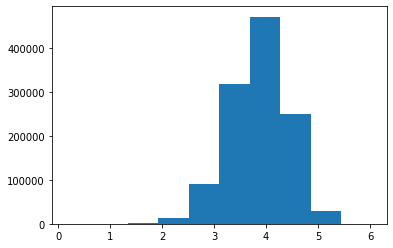

In [8]:
import matplotlib.pyplot as plt
plt.hist(final_preds)
plt.show()

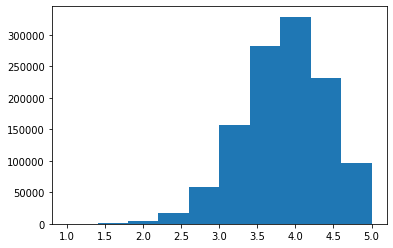

In [9]:
fps = np.copy(final_preds)
fps[fps > 5] = 5
fps[fps < 1] = 1
plt.hist(fps)
plt.show()

In [10]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
with open("./data/submissions/" + "ensemble_svp_svt_rsvd_10_instances" + "_" + timestamp + ".csv", "w") as f:
    f.write("Id,Prediction\n")
    for (user, movie, pred) in zip(test_users, test_movies, fps):
        f.write("r{}_c{},{}\n".format(user + 1, movie + 1, pred))

In [11]:
len([50,100,150,200,250,300,324,350,400,450])

10